In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import yfinance as yf
from keras import Input
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [29]:
plt.style.use('fivethirtyeight')

# Download Bitcoin data
stock_data = yf.download("BTC-USD", start="2020-01-01", end="2025-01-01", auto_adjust=False)

# Close price (make copy to avoid SettingWithCopyWarning)
closing_price = stock_data[['Close']].copy()

# Moving Averages
closing_price['MA_365'] = closing_price['Close'].rolling(window=365).mean()
closing_price['MA_100'] = closing_price['Close'].rolling(window=100).mean()

[*********************100%***********************]  1 of 1 completed


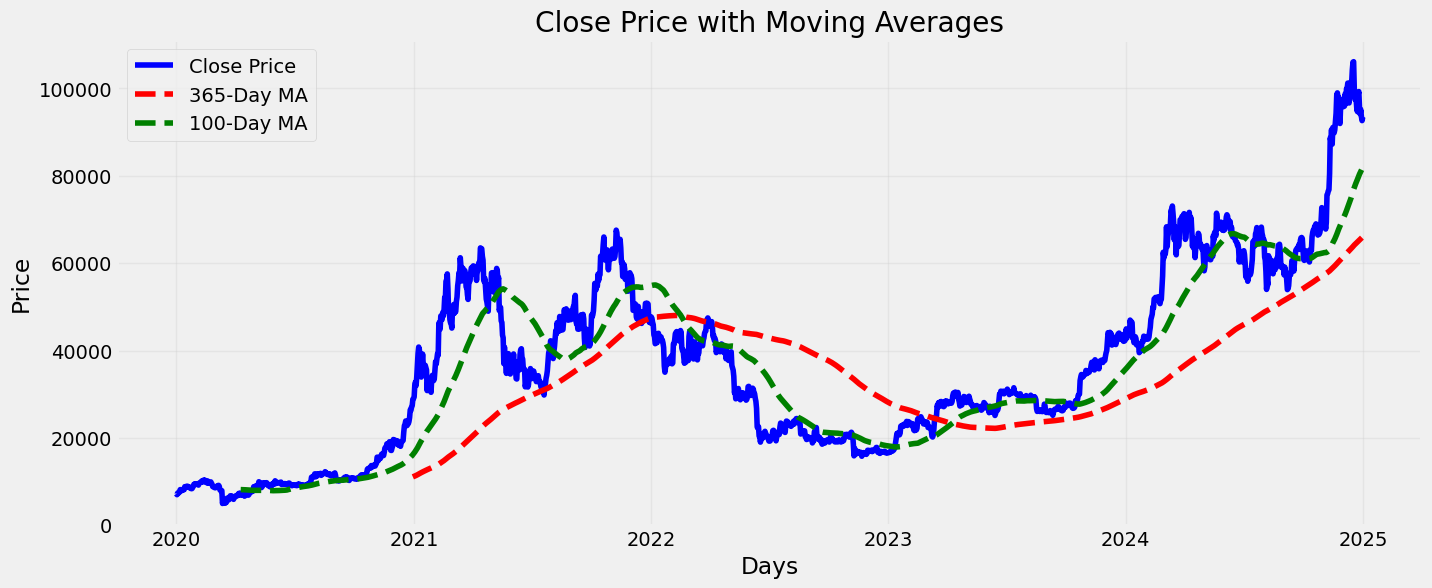

In [13]:
# Plotting close price and moving averages
plt.figure(figsize=(15, 6))
plt.plot(closing_price.index, closing_price['Close'], label='Close Price', color='blue')
plt.plot(closing_price.index, closing_price['MA_365'], label='365-Day MA', color='red', linestyle='--')
plt.plot(closing_price.index, closing_price['MA_100'], label='100-Day MA', color='green', linestyle='--')
plt.title("Close Price with Moving Averages")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [35]:
# Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_price[['Close']].dropna())

# Prepare LSTM data
x_data, y_data = [], []
base_days = 100
for i in range(base_days, len(scaled_data)):
    x_data.append(scaled_data[i-base_days:i])
    y_data.append(scaled_data[i])
x_data, y_data = np.array(x_data), np.array(y_data)

# Train-test split
train_size = int(len(x_data) * 0.8)
x_train, y_train = x_data[:train_size], y_data[:train_size]
x_test, y_test = x_data[train_size:], y_data[train_size:]



# LSTM Model (fixed)
model = Sequential([
    Input(shape=(x_train.shape[1], 1)),   # Explicit input layer
    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(x_train, y_train, batch_size=5, epochs=10)
model.save("model.keras")

# Predictions with LSTM
predictions = model.predict(x_test)
inv_predictions = scaler.inverse_transform(predictions)
inv_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Flatten for ML models
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)


Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - loss: 0.0033
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - loss: 7.5464e-04
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - loss: 6.0561e-04
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - loss: 3.3718e-04
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - loss: 4.2247e-04
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - loss: 2.3309e-04
Epoch 7/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - loss: 2.2218e-04
Epoch 8/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - loss: 2.4105e-04
Epoch 9/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - loss: 1.9788e-04
Epoch 10/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 23s 84ms/step - loss: 2.1872e-04
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


Linear Regression R² Score: 0.9797
Linear Regression RMSE: 1998.44


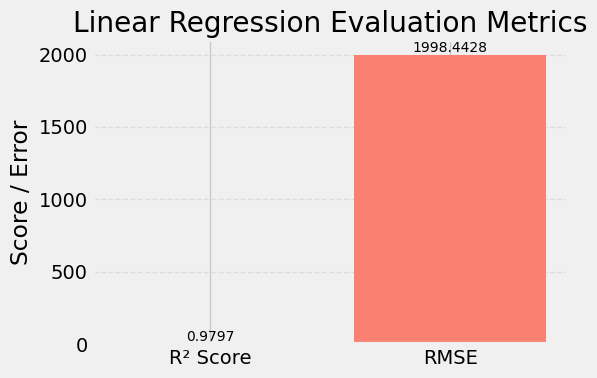

In [36]:
# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(x_train_flat, y_train)
lr_pred = lr_model.predict(x_test_flat)
inv_lr_pred = scaler.inverse_transform(lr_pred.reshape(-1, 1))

# Evaluation Metrics for Linear Regression
lr_r2 = r2_score(inv_y_test, inv_lr_pred)
lr_rmse = np.sqrt(mean_squared_error(inv_y_test, inv_lr_pred))

print(f"Linear Regression R² Score: {lr_r2:.4f}")
print(f"Linear Regression RMSE: {lr_rmse:.2f}")

# Plot the Evaluation Metrics for Linear Regression
# Plotting R² and RMSE for Linear Regression
plt.figure(figsize=(6, 4))
metrics = ['R² Score', 'RMSE']
values = [lr_r2, lr_rmse]
colors = ['skyblue', 'salmon']

bars = plt.bar(metrics, values, color=colors)
plt.title("Linear Regression Evaluation Metrics")
plt.ylabel("Score / Error")

# Annotate bars with values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [32]:
# Decision Tree Model
dt_model = DecisionTreeRegressor()
dt_model.fit(x_train_flat, y_train)
dt_pred = dt_model.predict(x_test_flat)
inv_dt_pred = scaler.inverse_transform(dt_pred.reshape(-1, 1))

In [37]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train_flat, y_train.ravel())   # 👈 fix applied
rf_pred = rf_model.predict(x_test_flat)
# Inverse transform
inv_rf_pred = scaler.inverse_transform(rf_pred.reshape(-1, 1))


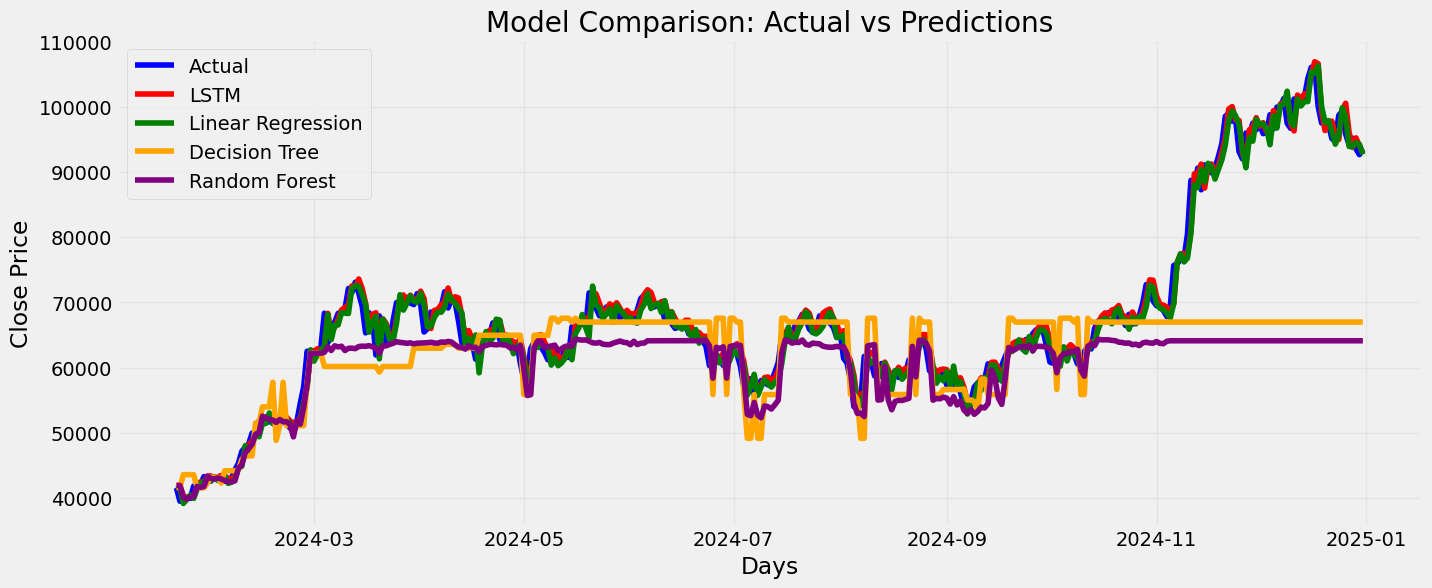

In [28]:
# Plot predictions comparison
plot_index = closing_price.index[train_size + base_days:]
plt.figure(figsize=(15, 6))
plt.plot(plot_index, inv_y_test.flatten(), label='Actual', color='blue')
plt.plot(plot_index, inv_predictions.flatten(), label='LSTM', color='red')
plt.plot(plot_index, inv_lr_pred.flatten(), label='Linear Regression', color='green')
plt.plot(plot_index, inv_dt_pred.flatten(), label='Decision Tree', color='orange')
plt.plot(plot_index, inv_rf_pred.flatten(), label='Random Forest', color='purple')

plt.title("Model Comparison: Actual vs Predictions")
plt.xlabel("Days")
plt.ylabel("Close Price")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


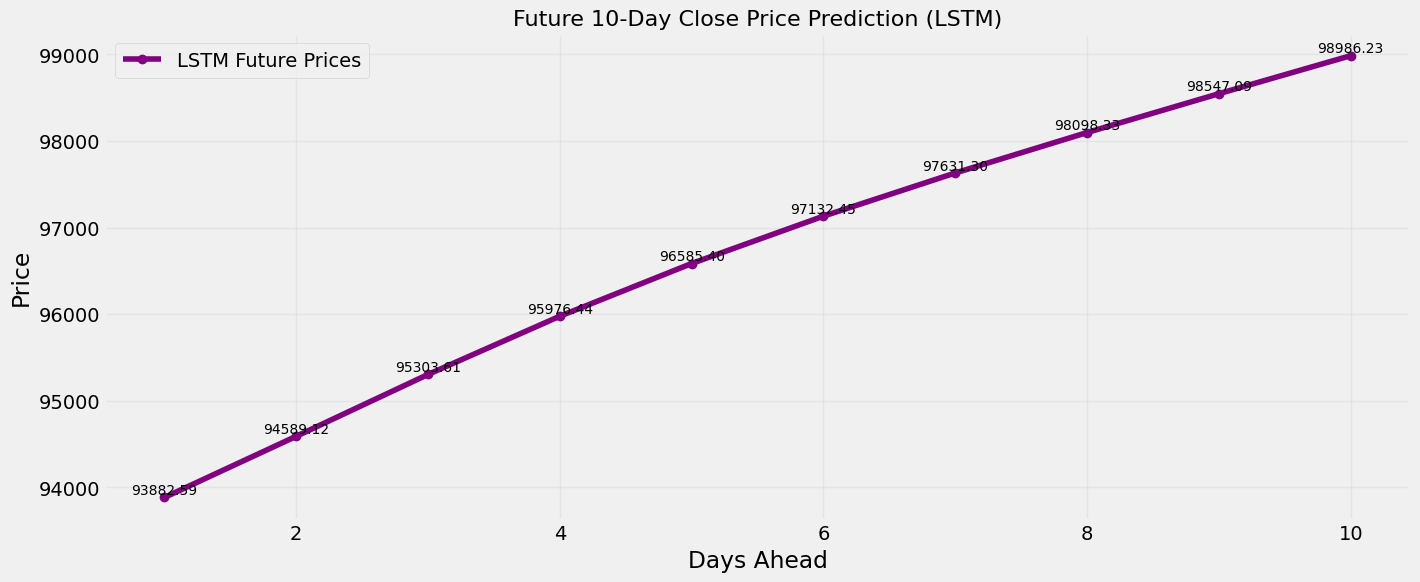

In [27]:
# Future Prediction (LSTM only)
last_100 = scaled_data[-100:].reshape(1, -1, 1)
future_predictions = []
for _ in range(10):
    next_day = model.predict(last_100)
    future_predictions.append(scaler.inverse_transform(next_day))
    last_100 = np.append(last_100[:, 1:, :], next_day.reshape(1, 1, -1), axis=1)

future_predictions = np.array(future_predictions).flatten()

# Plot future prediction
plt.figure(figsize=(15, 6))
plt.plot(range(1, 11), future_predictions, marker="o", label='LSTM Future Prices', color='purple')
for i, val in enumerate(future_predictions):
    plt.text(i+1, val, f'{val:.2f}', fontsize=10, ha='center', va='bottom', color='black')

plt.title("Future 10-Day Close Price Prediction (LSTM)", fontsize=16)
plt.xlabel("Days Ahead")
plt.ylabel("Price")
plt.grid(alpha=0.3)
plt.legend()
plt.show()
